# Group Final Report

### Christin Wang, Rongze Wang

## I. Introduction


## 1. Data Description ##
In this project, we will use the dataset `processed.cleveland.data`, which contains data on the heart quality variables of 302 patients and their identity variables undergoing angiography at the Cleveland Clinic in Cleveland, Ohio. The database selects 14 varaibles from 76 attributions. The data comes from the UCI Machine Learning repository https://doi.org/10.24432/C52P4X.

The definition of each selected variable:
1. `age`: age in years
2. `sex`: sex (1 = male; 0 = female)
3. `cp`: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. `trestbps`: resting blood pressure (in mm Hg on admission to the hospital)
5. `chol`: serum cholestoral in mg/dl
6. `fbs`: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. `restecg`: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. `thalach`: maximum heart rate achieved
9. `exang`: exercise induced angina (1 = yes; 0 = no)
10. `oldpeak`: ST depression induced by exercise relative to rest
11. `slope`: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. `ca`: number of major vessels (0-3) colored by fluoroscopy
13. `thal`: 3 = normal; 6 = fixed defect; 7 = reversible defect
14. `num`: diagnosis of heart disease
    - Value 0: absence
    - Value 1,2,3,4: presence

## 2. Question & Literature Reviews

As Coronary Artery Disease (CAD) is identified as one of the most leading reasons of mortality, scientists have been widely studied on the possible causes of CAD (Jones, L., et al., 1999, Inouye, M., et al., 2018).

The lifetime risk of CAD is significantly high, with men being more at risk than women, and the risk remains substantial among older individuals. Additionally, high blood pressure and hypercholesterolemia, characterized by elevated cholesterol levels, are major contributors to the risk of CAD (Lloyd-Jones, Larson, Beiser, & Levy, 1999).

Meanwhile, Inouye et al. (2018) highlighted that the occurrence of CAD can be associated with genetic characteristics. Although diabetes, which leads to high blood sugar, can be inherited, it has rarely been included in previous research. While extensive studies have focused on factors like age, sex, blood pressure, and cholesterol level, the role of blood sugar remains unclear.

This leads to our question: **“Are sex, age, blood pressure, cholesterol level and blood sugar associated with heart disease diagnosis in the Cleveland dataset?”**

To address this, we will use the Cleveland heart disease dataset (Janosi et al., 1988) to estimate the association between heart disease diagnosis and these factors. The dataset includes 13 variables and 1 response variable, collected from medical records for heart disease research. Its primary use is to distinguish between the presence (values 1, 2, 3, 4) and absence (value 0) of heart disease.


## II. Methods and Results

### A. Exploratory Data Analysis

In [1]:
library(MASS)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(modelr)
library(gridExtra)
library(grid)
library(rsample)
library(yardstick)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(caret)
library(ISLR)
library(pROC)

Warning message:
"程辑包'tidyverse'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'forcats'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'lubridate'是用R版本4.3.3 来建造的"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"程辑包'infer'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'cowplot'是用R版本4.3.3 来建造的"

载入程辑包：'cowplot'


The following object is masked from 'package:lubridate':

    stamp


Warning message:
"程辑包'broom'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'GGally'是用R版本4.3.3 来建造的"
Registered S3 method

### 1. Data Preparation

- Read the csv file of `processed.cleveland.data`.
- Rename the column names of the dataset.
- Change the diagnosis presence values (1,2,3,4) all into 1.
- Mutate all catagorical variables into factors for coding convinience.
- Drop any NA values.

In [2]:
# Main developer: Christin Wang

heart_data <- read_csv("https://raw.githubusercontent.com/Speculatorrr/STAT301/main/processed.cleveland.data?token=GHSAT0AAAAAACVKAVDCISXAPJBRTBVAWBUQZVEDPNQ", 
                        col_names = FALSE)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol",
                            "fbs", "restecg", "thalach", "exang", "oldpeak",
                            "slope", "ca", "thal", "num")

categorical_vars <- c("sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal")

heart_data <- heart_data %>%
    mutate(num = if_else(num > 0, 1, 0)) %>%
    mutate(across(all_of(categorical_vars), as.factor),
    num = as.factor(num)) %>%
    drop_na()

head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Table 1: Tidy Cleveland heart disease data

### 2. Plotting relevant raw data

**2.1 Bar Chart of Categorical Variables Labeled by Heart Disease Diagnosis Results**

- This graph compares the frequencies of diagnosis results within 8 different categorical variables, and identifies which categorical variables are more strongly associated with heart disease. 

    In this case, we see that `cp`, `restecg`, `exang`, `slope`, `ca` and `thal` have a relatively stronger association with the presence of heart disease.

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


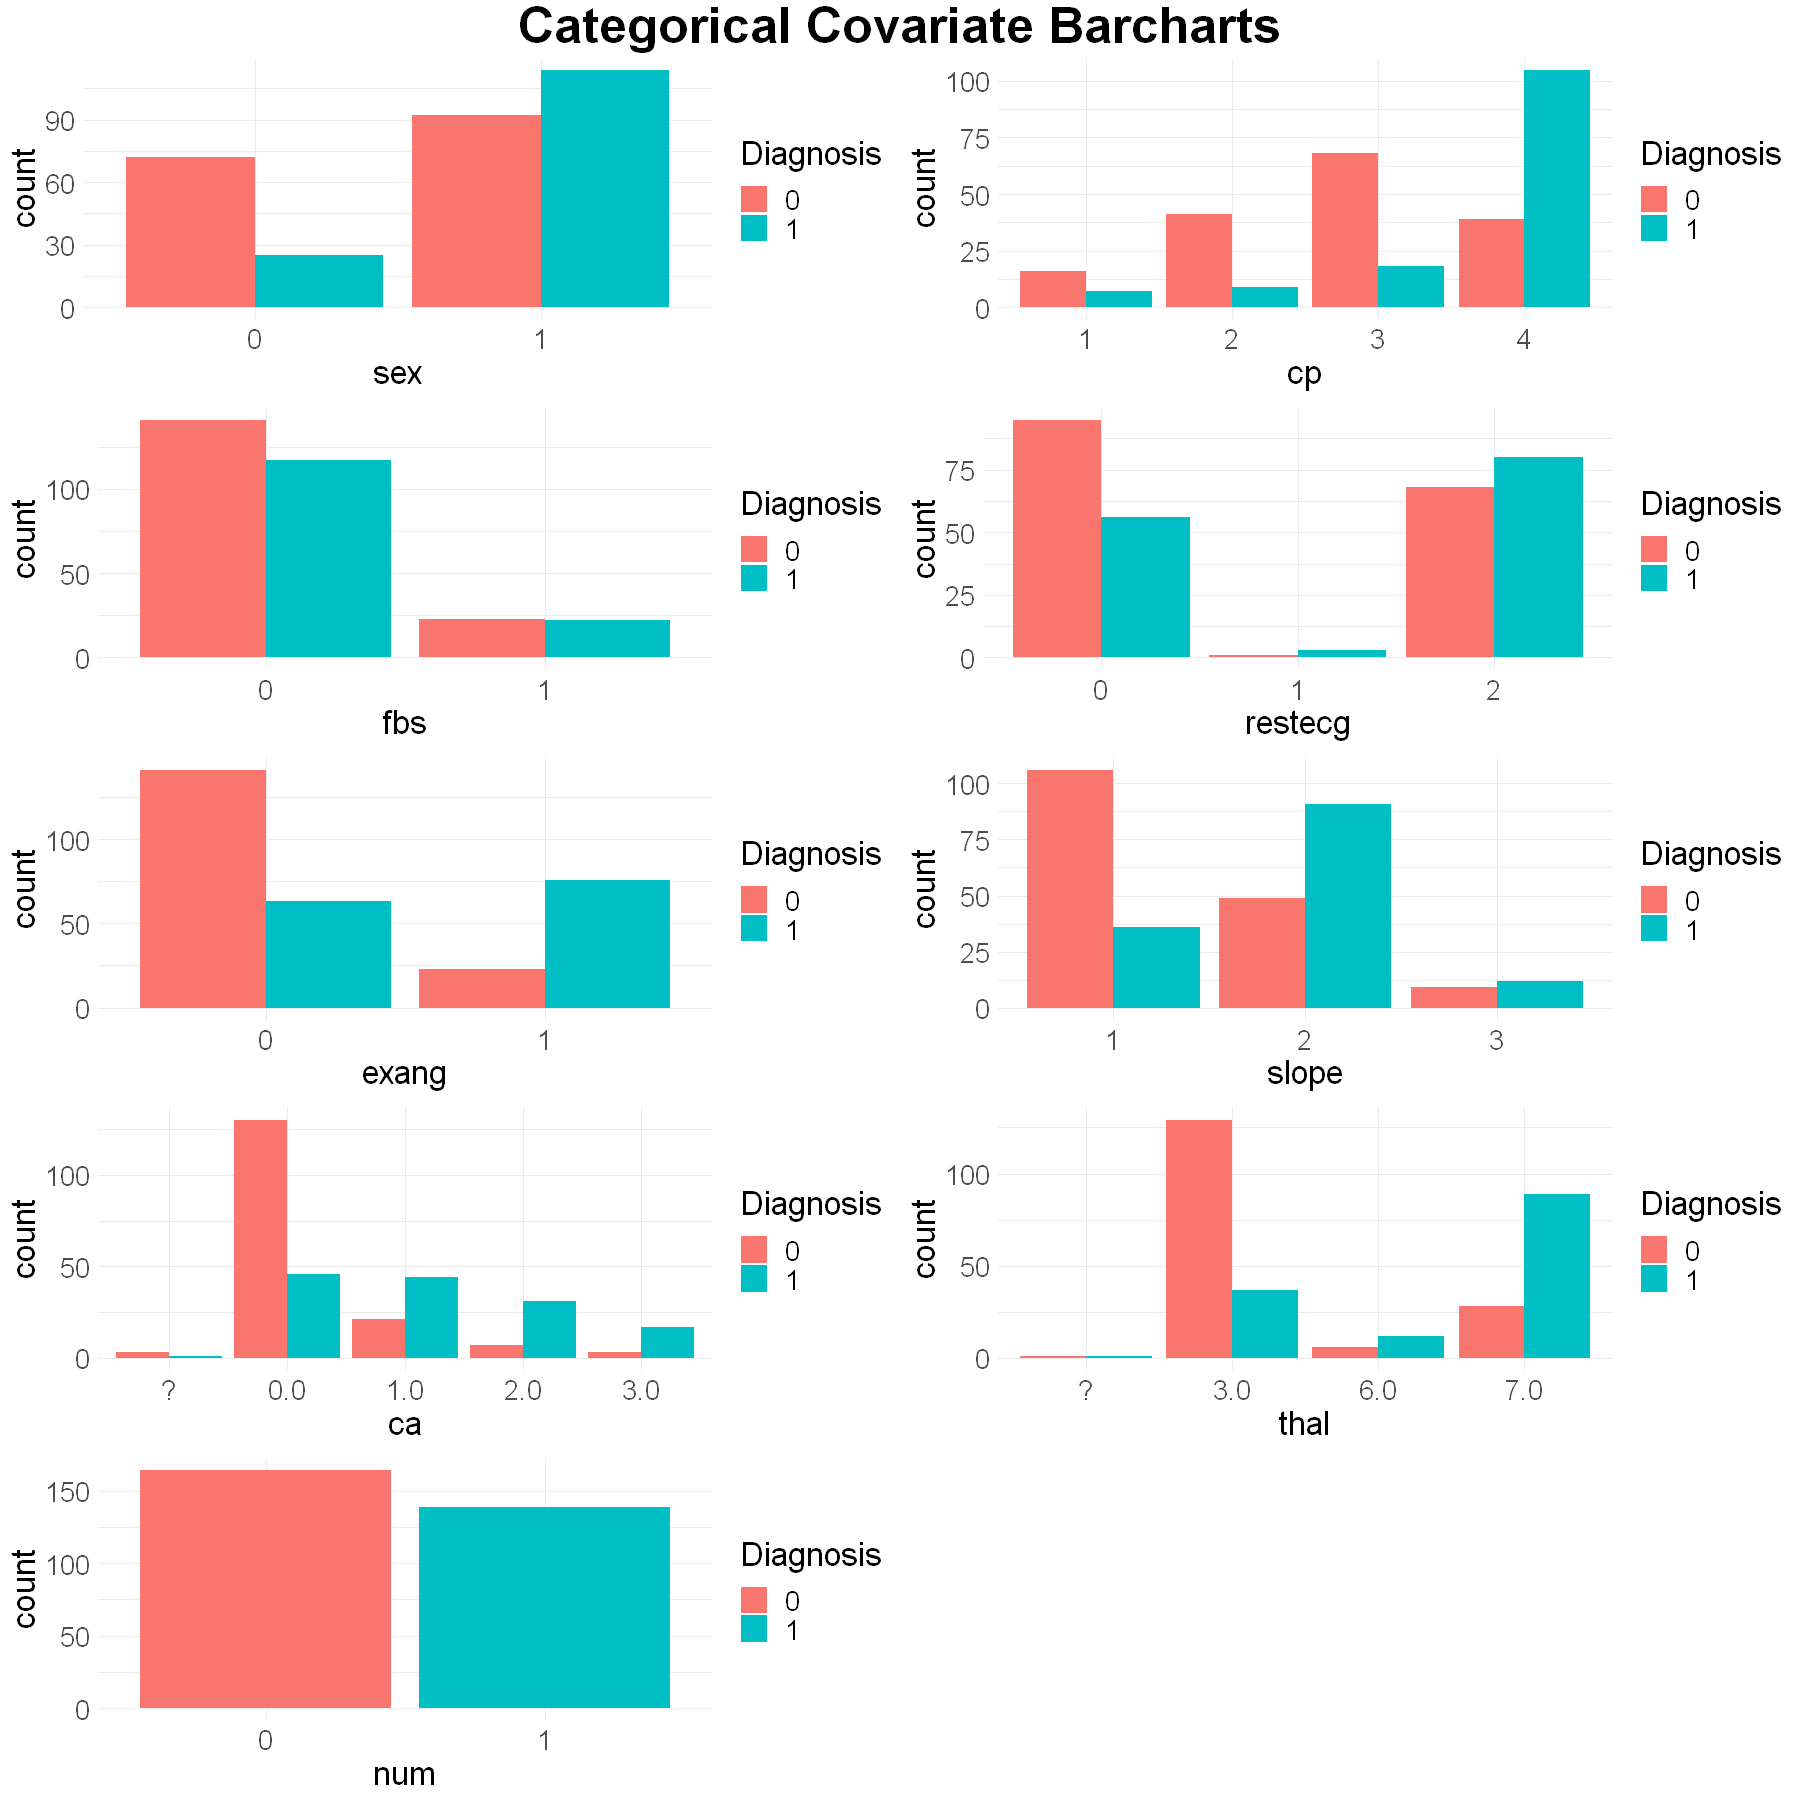

In [4]:
# Main developer: Christin Wang
options(repr.plot.width = 15, repr.plot.height = 15) 

draw_bar_chart <- function(data, categorical_vars, num) {
  ggplot(data, aes_string(x = categorical_vars, fill = num)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = categorical_vars, fill = "Diagnosis")
}

sex_bar <- draw_bar_chart(heart_data, "sex", "num")
cp_bar <- draw_bar_chart(heart_data, "cp", "num")
fbs_bar <- draw_bar_chart(heart_data, "fbs", "num")
restecg_bar <- draw_bar_chart(heart_data, "restecg", "num")
exang_bar <- draw_bar_chart(heart_data, "exang", "num")
slope_bar <- draw_bar_chart(heart_data, "slope", "num")
ca_bar <- draw_bar_chart(heart_data, "ca", "num")
thal_bar <- draw_bar_chart(heart_data, "thal", "num")
num_bar <- draw_bar_chart(heart_data, "num", "num")

grid.arrange(
  sex_bar, cp_bar, fbs_bar, restecg_bar,
  exang_bar, slope_bar, ca_bar, thal_bar, num_bar,
  ncol = 2,
  top = textGrob("Categorical Covariate Barcharts", gp = gpar(fontsize = 30, fontface = "bold"))
)

Figure 1: Categorical Covariate Barcharts

**2.2 Correlation Matrix Heatmap of Numerical Variables**

- Within this heatmap, `trestbps`&`age`, `age`&`thalach`, `oldpeak`&`thalach` are shown to have the strongest correlation. So, we might want to put multicollinearity into concern for these variables, probably dropping one afterwards.
    

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(categorical_vars)

  # Now:
  data %>% select(all_of(categorical_vars))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


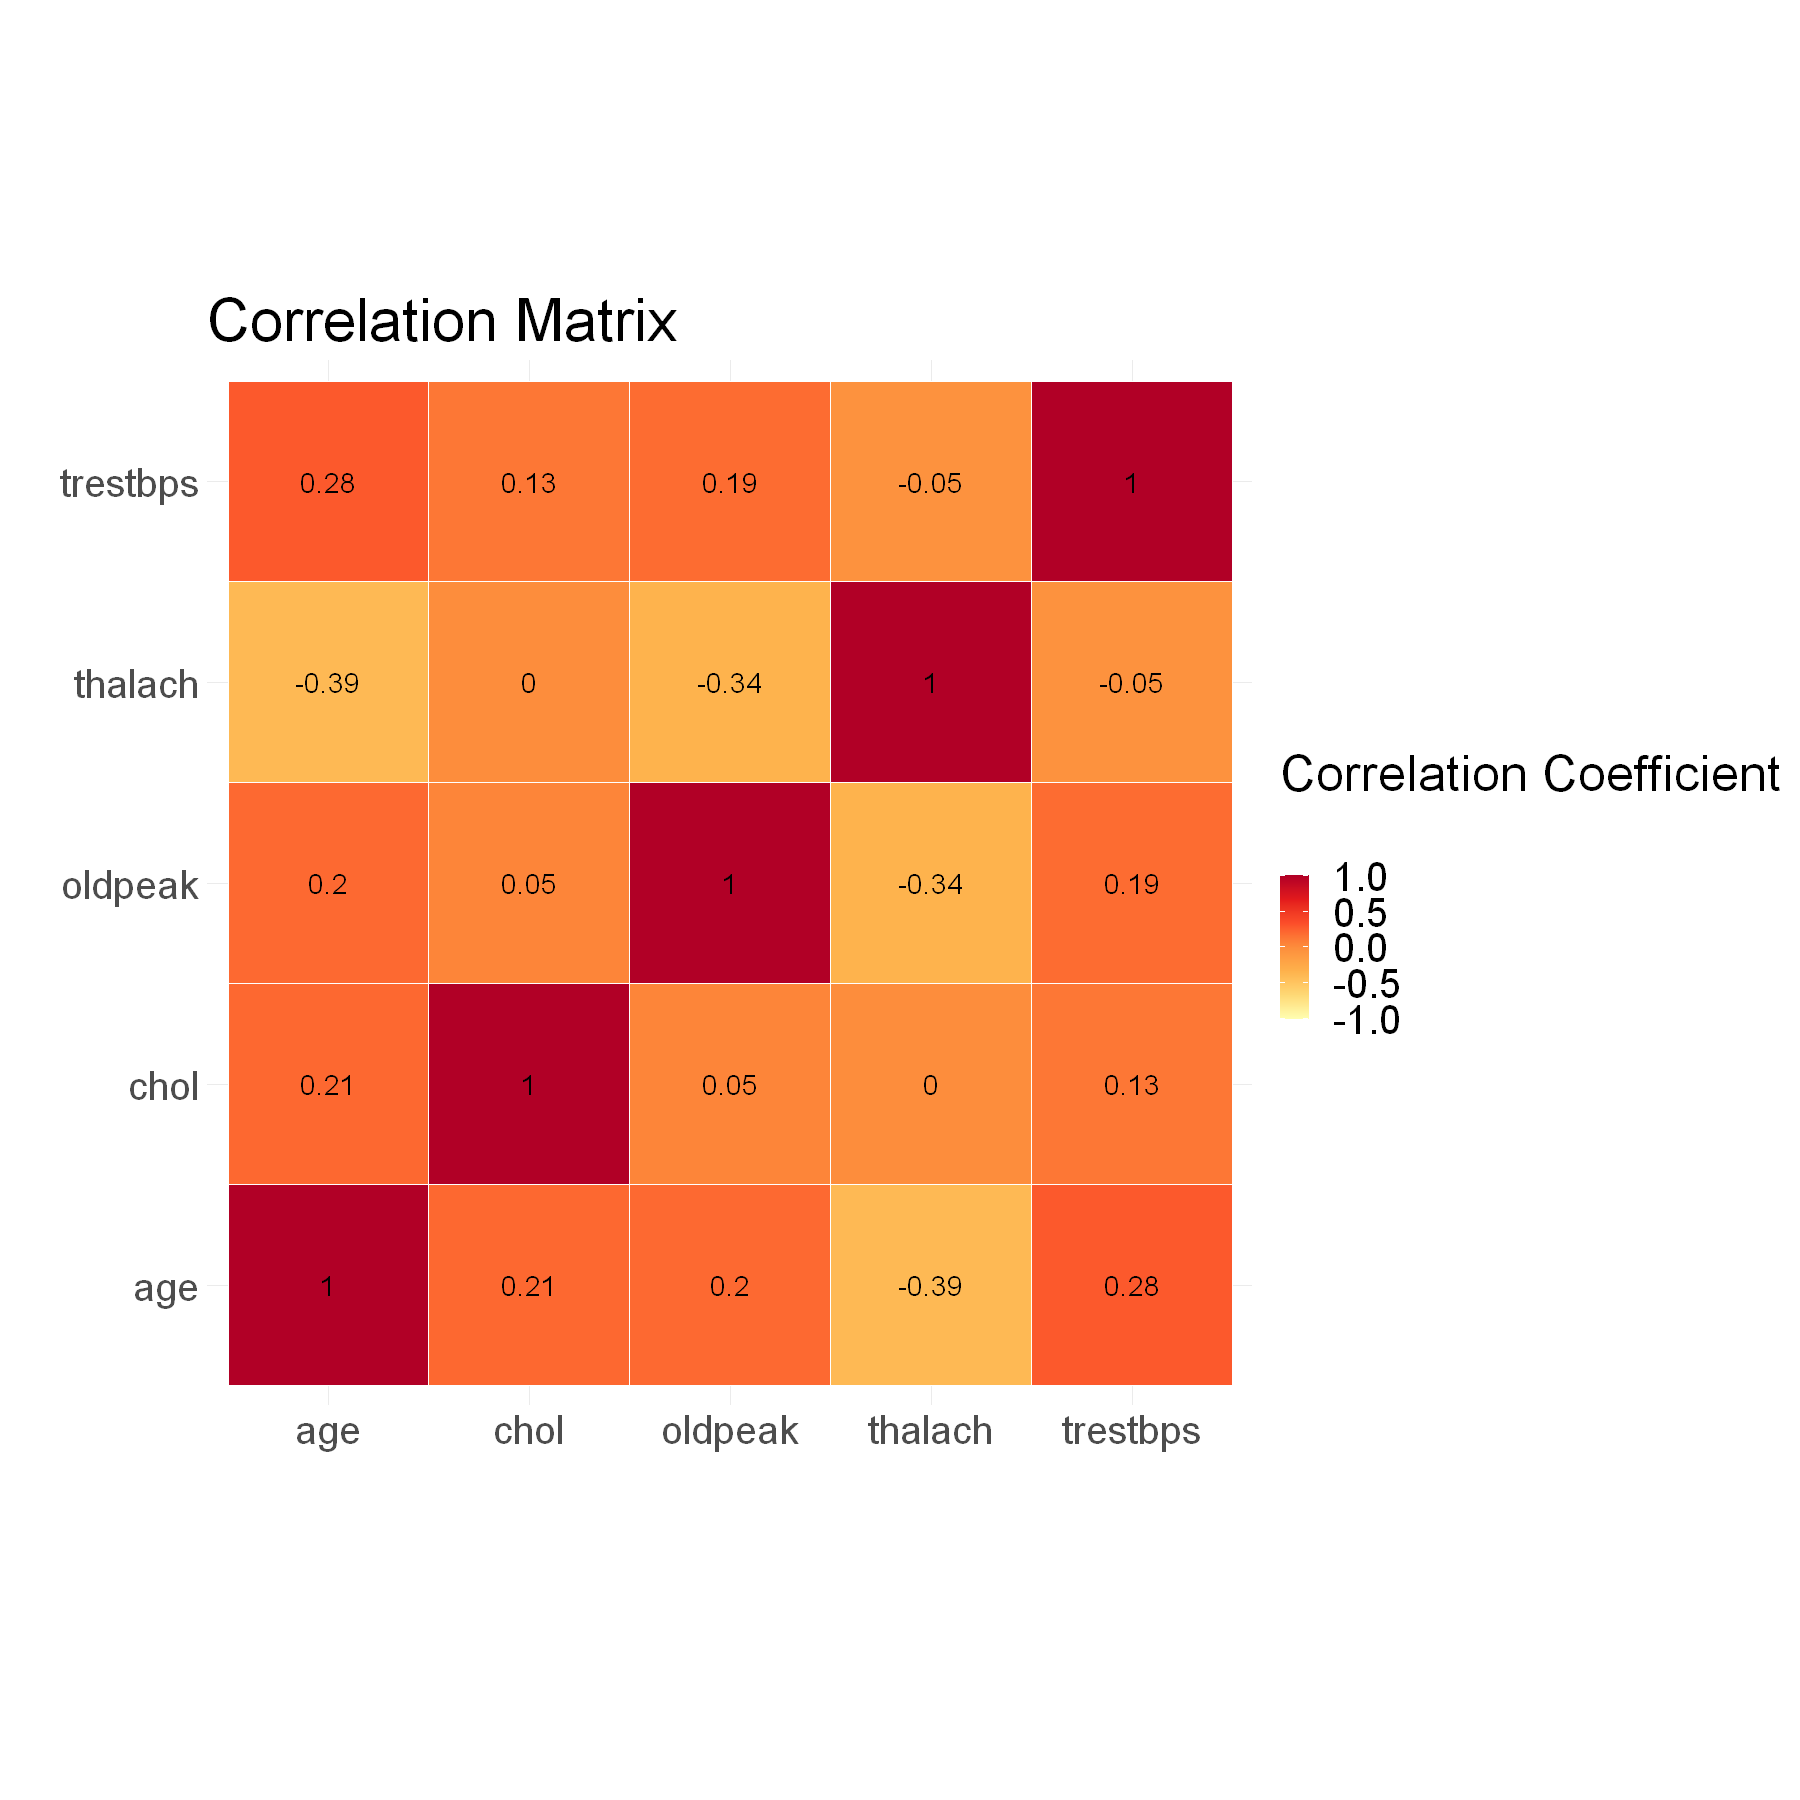

In [5]:
# Main developer: Christin Wang

corr_matrix <- heart_data %>%
            select(-categorical_vars, -num) %>%
            cor() %>%
            as_tibble(rownames = 'var1') %>%
            pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix <- corr_matrix %>%
   ggplot(aes(var1, var2)) +
   geom_tile(aes(fill = corr), color = "white") +
   scale_fill_distiller("Correlation Coefficient \n",
       palette =  "YlOrRd",
       direction = 1, 
       limits = c(-1, 1)
     ) +
     labs(x = "", y = "") +
     theme_minimal() +
     theme(text = element_text(size = 30)) +
     coord_fixed() +
   geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6) +
   ggtitle("Correlation Matrix")

plot_corr_matrix

Figure 2: Correlation Matrix

**2.3 Boxplots Comparing Heart Disease Diagnosis between Numerical Variables**

- We can easily see the differences in the distribution of values, including the presence of outliers, mean, median and variability. 

    We will compare the median since the mean may be affected by outliers.
    In this case, we see that `age`, `oldpeak` and `thalach` has a relatively big differences between diagnosis results. Thus, may be more useful in the prediction model.


Warning message:
"The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead."


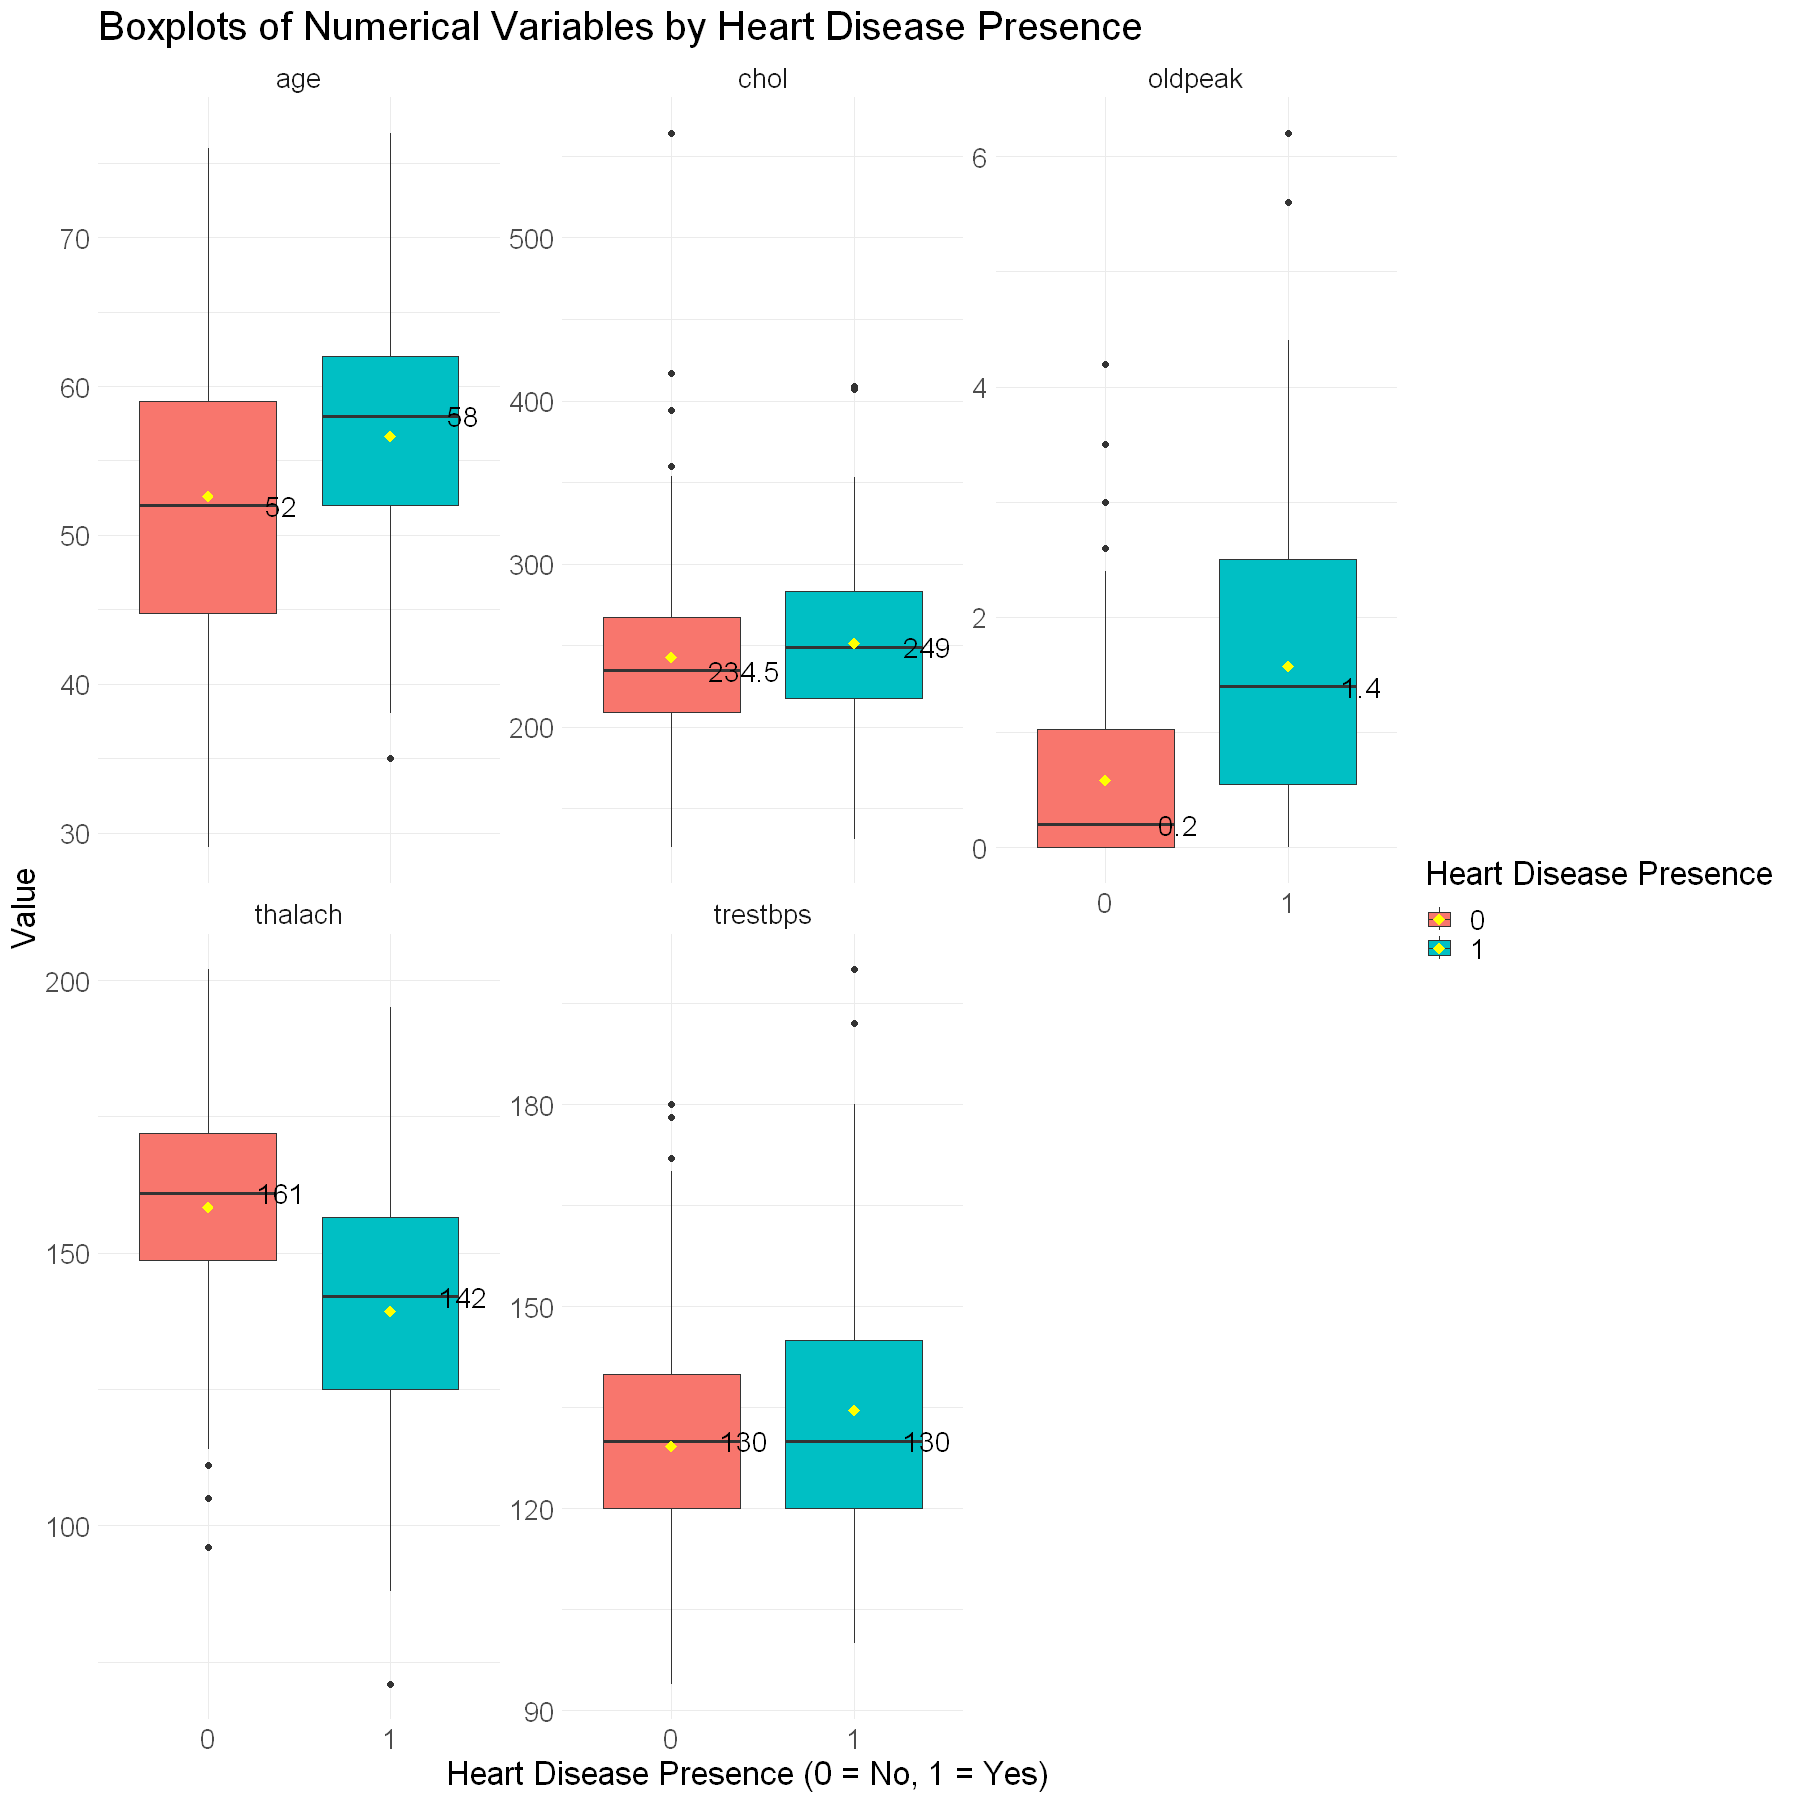

In [6]:
# Main developer: Christin Wang

heart_long <- heart_data %>%
  select(- categorical_vars) %>%
  pivot_longer(cols = -num , names_to = "variable", values_to = "value")

heart_boxplot <- heart_long %>%
  ggplot(aes(x = as.factor(num), y = value, fill = as.factor(num))) +
  geom_boxplot() +
  stat_summary(aes(label = round(..y.., 2)),
               fun = median,
               geom = "text",
               position = position_nudge(x = 0.4, y = 0),
               size = 6) +
  facet_wrap(~ variable, scales = "free_y") +
  stat_summary(aes(as.factor(num), value, fill = as.factor(num)),
               fun = mean,
               colour = "yellow",
               geom = "point",
               shape = 18,
               size = 3) +
  theme_minimal() +
  theme(text = element_text(size = 20)) +
  labs(title = "Boxplots of Numerical Variables by Heart Disease Presence", 
       x = "Heart Disease Presence (0 = No, 1 = Yes)", y = "Value") +
  scale_fill_discrete(name = "Heart Disease Presence")
heart_boxplot

Figure 3: Numerical Coveriate Boxplots



#### Visualization Conclusion

After looking into the 4 graphs, we get a comprehensive overview of the data. At this point, we assume that `age`, `oldpeak`, `thalach`, `cp`, `restecg`, `exang`, `slope`, `ca` and `thal`, these 9 covariates are more relevant to heart disease diagnosis. Additionally, there may be multicollinearity amongst the variables `trestbps`,`age`, `thalach` and `oldpeak`.

### B. Methods

### 1. Split data into train & test

In [7]:
# Main developer: Christin Wang

heart_split <- 
    heart_data %>%
    initial_split(prop = 0.7, strata = num)
    
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### 2. Fit the full Logistic Regression model by the training set

In [42]:
# Main developer: Christin Wang

heart_full_log <- glm(num ~ .,
                data = heart_train,
                family = binomial)

summary(heart_full_log)


Call:
glm(formula = num ~ ., family = binomial, data = heart_train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)  5.995e+00  1.455e+03   0.004  0.99671   
age          1.634e-03  3.060e-02   0.053  0.95743   
sex1         1.543e+00  6.892e-01   2.239  0.02516 * 
cp2          1.769e+00  1.094e+00   1.617  0.10591   
cp3          9.061e-01  9.258e-01   0.979  0.32771   
cp4          2.850e+00  9.300e-01   3.064  0.00218 **
trestbps     3.237e-02  1.569e-02   2.064  0.03906 * 
chol         1.273e-03  4.861e-03   0.262  0.79342   
fbs1        -1.353e+00  8.674e-01  -1.560  0.11879   
restecg1     5.520e-01  3.181e+00   0.174  0.86224   
restecg2     9.355e-01  5.017e-01   1.865  0.06223 . 
thalach     -8.285e-03  1.556e-02  -0.533  0.59432   
exang1       1.285e+00  5.667e-01   2.268  0.02335 * 
oldpeak      6.857e-01  3.182e-01   2.155  0.03114 * 
slope2       8.576e-01  6.333e-01   1.354  0.17566   
slope3      -2.145e-01  1.214e+00  -0.177  0.85970  

Table 2: Full logistic regression model summary

### 3. Check for Collinarity by using `vif`

In [9]:
# Main developer: Christin Wang

vif_value <- vif(heart_full_log) 

vif_df <- data.frame(
  Variable = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"),
  GVIF_Adj = c(1.297, 1.357, 1.173, 1.261, 1.184, 1.099, 1.055, 1.220, 1.099, 1.360, 1.219, 1.145, 1.102)
  ) %>%
  arrange(desc(GVIF_Adj))
  
vif_df

Variable,GVIF_Adj
<chr>,<dbl>
oldpeak,1.360
sex,1.357
age,1.297
trestbps,1.261
thalach,1.220
slope,1.219
chol,1.184
cp,1.173
ca,1.145


Table 3: VIF table of covariates

#### VIF interpretation
No variable has a `GVIF_Adj` (adjusted GVIF) greater than 5, it generally suggests that multicollinearity is not a severe issue in our model.

### 4. Forward selection
Make a forward selection. Out of the 13 models, select the best one in terms of its goodness of fit (smallest AIC).

Then re-fit a logistic regression model with the selected variables

In [10]:
# Main developer: Christin Wang

null_model <- glm(num ~ 1, data = heart_data, family = binomial)

forward_sel <- stepAIC(null_model, direction = "forward", 
                         scope = list(lower = null_model, upper = heart_full_log))

summary(forward_sel)

Start:  AIC=419.98
num ~ 1

           Df Deviance    AIC
+ thal      3   330.60 338.60
+ cp        3   331.86 339.86
+ ca        4   341.72 351.72
+ oldpeak   1   357.20 361.20
+ exang     1   359.54 363.54
+ thalach   1   360.90 364.90
+ slope     2   370.76 376.76
+ sex       1   393.93 397.93
+ age       1   402.54 406.54
+ restecg   2   407.84 413.84
+ trestbps  1   411.03 415.03
+ chol      1   415.78 419.78
<none>          417.98 419.98
+ fbs       1   417.79 421.79

Step:  AIC=338.6
num ~ thal

           Df Deviance    AIC
+ ca        4   274.50 290.50
+ cp        3   279.14 293.14
+ thalach   1   297.00 307.00
+ oldpeak   1   300.05 310.05
+ exang     1   300.20 310.20
+ slope     2   307.31 319.31
+ age       1   320.14 330.14
+ restecg   2   318.53 330.53
+ sex       1   327.67 337.67
+ chol      1   327.79 337.79
+ trestbps  1   327.83 337.83
<none>          330.60 338.60
+ fbs       1   330.51 340.51

Step:  AIC=290.5
num ~ thal + ca

           Df Deviance    AIC
+ cp   


Call:
glm(formula = num ~ thal + ca + cp + oldpeak + slope + sex + 
    trestbps + exang, family = binomial, data = heart_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.78439    4.46368  -1.744  0.08117 .  
thal3.0     -2.24995    3.70784  -0.607  0.54398    
thal6.0     -2.47520    3.77569  -0.656  0.51211    
thal7.0     -0.83940    3.71096  -0.226  0.82105    
ca0.0        1.12685    1.63454   0.689  0.49057    
ca1.0        3.40654    1.69270   2.012  0.04417 *  
ca2.0        4.07792    1.81968   2.241  0.02503 *  
ca3.0        3.34023    1.84440   1.811  0.07014 .  
cp2          1.41765    0.79381   1.786  0.07412 .  
cp3          0.32082    0.68953   0.465  0.64173    
cp4          2.57209    0.69400   3.706  0.00021 ***
oldpeak      0.46158    0.22843   2.021  0.04332 *  
slope2       1.49041    0.46137   3.230  0.00124 ** 
slope3       0.64413    0.89013   0.724  0.46929    
sex1         1.47598    0.50889   2.900  0.00373 ** 
trestbps

Table 4,5 : Forward selection result summary

We observe that this model contains too many high p-values, which cannot be rejected using a significance level of 5%. Therefore, we aim to find a more refined model.

### 5. Find more reduced model
We apply two methods to identify a more reduced model:
#### 5.1. Remove insignificant terms 
We remove terms with p-values higher than 5%. (However, given the presence of many dummy variables, we cannot remove every insignificant term.)

In [12]:
# Main developer: Christin Wang
significant_vars <- forward_tidy %>%
    filter(p.value < 0.05) %>%
    pull(term) 
significant_vars

[1] "ca1.0"    "ca2.0"    "cp4"      "oldpeak"  "slope2"   "sex1"     "trestbps"

In [34]:
# Main developer: Christin Wang
more_red_log <- glm(
    formula = num ~ ca + cp + oldpeak + slope + sex + trestbps,
    data = heart_train,
    family = "binomial"
)

summary(more_red_log)


Call:
glm(formula = num ~ ca + cp + oldpeak + slope + sex + trestbps, 
    family = "binomial", data = heart_train)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.66874    2.69926  -3.582 0.000341 ***
ca0.0        0.09569    1.56735   0.061 0.951318    
ca1.0        2.29398    1.61161   1.423 0.154620    
ca2.0        2.05407    1.75977   1.167 0.243114    
ca3.0        3.01492    1.98999   1.515 0.129760    
cp2          1.50526    0.97983   1.536 0.124478    
cp3          0.69650    0.83514   0.834 0.404288    
cp4          3.30644    0.83473   3.961 7.46e-05 ***
oldpeak      0.72511    0.26516   2.735 0.006246 ** 
slope2       1.43066    0.51344   2.786 0.005329 ** 
slope3       0.16277    1.01667   0.160 0.872803    
sex1         1.84231    0.52573   3.504 0.000458 ***
trestbps     0.02886    0.01272   2.269 0.023283 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)



Table 6: More reduced logistic regression model summary

#### 5.2. Lasso Regularization

In [14]:
# Main developer: Christin Wang
matrix_X_train <- 
    model.matrix(object = num ~., 
                data = heart_train) [, -1]

matrix_Y_train <- heart_train$num

cv_lambda_lasso <- 
   cv.glmnet(
        x = matrix_X_train, 
        y = matrix_Y_train,
        alpha = 1,
        family = "binomial",
        type.measure = "auc",
        nfolds = 10)
        
LASSO <- 
   glmnet(
   x = matrix_X_train, 
   y = matrix_Y_train,
   alpha = 1,
   family = "binomial",
   lambda = cv_lambda_lasso$lambda.min
 )
 coef(LASSO)

23 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  0.331078327
age          .          
sex1         .          
cp2          .          
cp3          .          
cp4          0.733683966
trestbps     .          
chol         .          
fbs1         .          
restecg1     .          
restecg2     .          
thalach     -0.001356041
exang1       0.680339970
oldpeak      0.196744317
slope2       .          
slope3       .          
ca0.0       -0.783249671
ca1.0        .          
ca2.0        .          
ca3.0        .          
thal3.0     -1.087803698
thal6.0      .          
thal7.0      .          

Table 7: Lasso coefficient with minimum lambda

In [15]:
# Main developer: Christin Wang
selected_data <- heart_train %>%
select(age, sex, cp, trestbps, chol, restecg, thalach, exang, oldpeak, slope, ca, thal, num) 

matrix_X_selected <- model.matrix(num ~ ., data = selected_data)[, -1]
matrix_Y_selected <- selected_data$num

lasso_model <- glm(
  formula = num ~ ., 
  data = selected_data, 
  family = "binomial"
)

summary(lasso_model)


Call:
glm(formula = num ~ ., family = "binomial", data = selected_data)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.207e+00  1.455e+03   0.004 0.997145    
age         -4.428e-03  3.034e-02  -0.146 0.883948    
sex1         1.382e+00  6.715e-01   2.058 0.039637 *  
cp2          2.087e+00  1.073e+00   1.946 0.051637 .  
cp3          1.075e+00  8.905e-01   1.208 0.227196    
cp4          3.055e+00  9.275e-01   3.294 0.000989 ***
trestbps     2.830e-02  1.518e-02   1.864 0.062334 .  
chol         1.135e-03  4.834e-03   0.235 0.814393    
restecg1     7.282e-01  3.174e+00   0.229 0.818517    
restecg2     9.619e-01  5.012e-01   1.919 0.054958 .  
thalach     -9.705e-03  1.529e-02  -0.635 0.525527    
exang1       1.262e+00  5.618e-01   2.246 0.024677 *  
oldpeak      7.226e-01  3.168e-01   2.281 0.022573 *  
slope2       7.451e-01  6.134e-01   1.215 0.224500    
slope3      -2.960e-01  1.205e+00  -0.246 0.805896    
ca0.0        1.084e+00  2.020e+0

Table 8: Lasso model summary

### 6. Model Evaluation

Now, we can test the performance of our new logistic regression model on test set by using Confusion matrix and ROC graphs

In [18]:
# Main developer: Rongze Wang
heart_full_log_testing <- glm(num ~ .,
                data = heart_test,
                family = binomial)
heart_pred_class <- 
        round(predict(heart_full_log_testing,type="response"),0)
head(heart_pred_class, 10)

1  2  3  4  5  6  7  8  9 10 
 0  1  0  1  1  0  0  0  0  0

In [19]:
# Main developer: Rongze Wang
heart_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(heart_pred_class),
    reference = as.factor(heart_test$num),
    positive = '1'
)
heart_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 48  4
         1  2 38
                                          
               Accuracy : 0.9348          
                 95% CI : (0.8634, 0.9757)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8681          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9048          
            Specificity : 0.9600          
         Pos Pred Value : 0.9500          
         Neg Pred Value : 0.9231          
             Prevalence : 0.4565          
         Detection Rate : 0.4130          
   Detection Prevalence : 0.4348          
      Balanced Accuracy : 0.9324          
                                          
       'Positive' Class : 1               
                                    

Table 9: Full model confusion matrix

In [20]:
# Main developer: Rongze Wang
heart_new_pred_class <- 
        round(predict(forward_sel,type="response", newdata=heart_test),0)
head(heart_new_pred_class, 10)

1  2  3  4  5  6  7  8  9 10 
 0  1  0  1  1  0  0  0  0  0

In [21]:
# Main developer: Rongze Wang
heart_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(heart_new_pred_class),
    reference = as.factor(heart_test$num),
    positive = '1'
)
heart_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 46  6
         1  4 36
                                          
               Accuracy : 0.8913          
                 95% CI : (0.8092, 0.9466)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 6.36e-13        
                                          
                  Kappa : 0.7801          
                                          
 Mcnemar's Test P-Value : 0.7518          
                                          
            Sensitivity : 0.8571          
            Specificity : 0.9200          
         Pos Pred Value : 0.9000          
         Neg Pred Value : 0.8846          
             Prevalence : 0.4565          
         Detection Rate : 0.3913          
   Detection Prevalence : 0.4348          
      Balanced Accuracy : 0.8886          
                                          
       'Positive' Class : 1               
                                    

Table 10: Reduced model confusion matrix

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



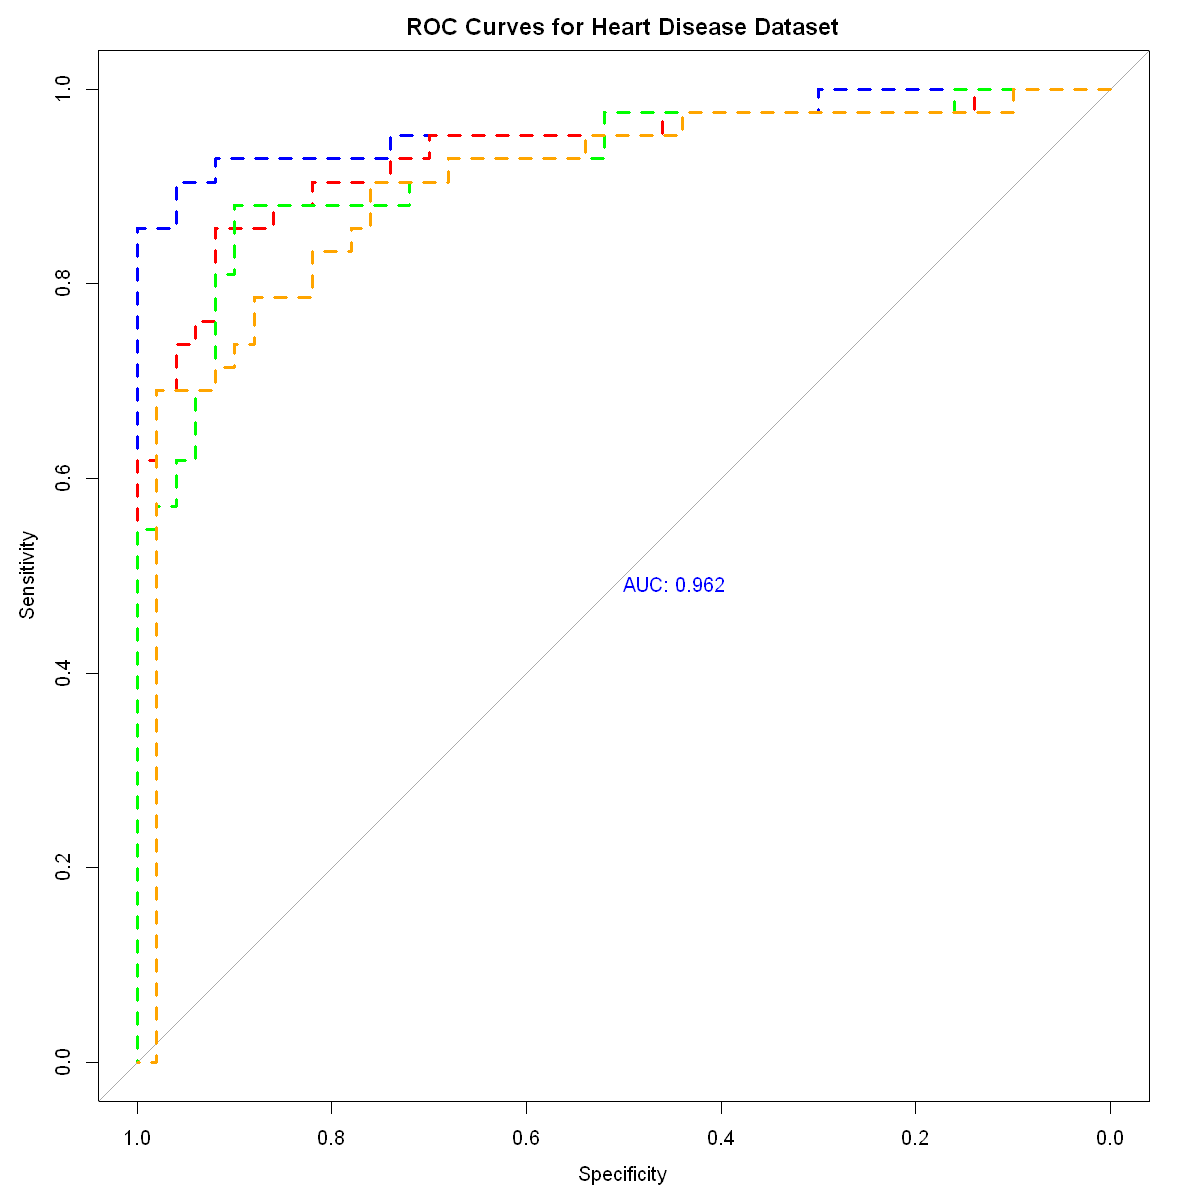

In [43]:
# Main developer: Rongze Wang

options(repr.plot.width = 10, repr.plot.height = 10)

ROC_full_log_testing <- roc(
  response = heart_test$num,
  predictor = predict(heart_full_log_testing,type='response')
)

ROC_red_log <- roc(
  response = heart_test$num,
  predictor = predict(forward_sel,type='response',newdata=heart_test)
)

ROC_more_red_log <- roc(
  response = heart_test$num,
  predictor = predict(more_red_log,type='response',newdata=heart_test)
)

ROC_lasso <- roc(
  response = heart_test$num,
  predictor = predict(lasso_model,type='response',newdata=heart_test)
)

plot(ROC_full_log_testing,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Heart Disease Dataset"
)
lines.roc(ROC_red_log,print.auc = TRUE, col = "red", lwd = 3, lty = 2)
lines.roc(ROC_more_red_log,print.auc = TRUE, col = "green", lwd = 3, lty = 2)
lines.roc(ROC_lasso,print.auc = TRUE, col = "orange", lwd = 3, lty = 2)

Figure 4: ROC curve for full, reduced, more reduced and lasso model

#### ROC curve interpretation
From the ROC curves above, the blue dot line represents the `heart_full_log`, the red dot line represents the `forward_sel`, the green line represents the `more_red_log`, and the orange line represents the `lasso_model`. We could see that the full logistic model has the largest AUC value which means that it performs the best fitting to the data. Meanwhile, the reduced model after forward selection has a lower AUC value than the full logistic model, and once we eliminate more insignificant variables, the value of AUC drops further. Besides, the lasso model also has a very low AUC value.

### 7. Interpretation

In [40]:
# Main developer: Rongze Wang
#Contributor: Christin Wang (round numeric)

more_reduced_tidy <- more_red_log %>%
     tidy(conf.int = 0.95) %>%
     mutate_if(is.numeric, round, 2)
more_reduced_tidy

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-9.67,2.70,-3.58,0.00,-15.30,-4.61
ca0.0,0.10,1.57,0.06,0.95,-2.94,3.56
ca1.0,2.29,1.61,1.42,0.15,-0.79,5.84
ca2.0,2.05,1.76,1.17,0.24,-1.32,5.83
ca3.0,3.01,1.99,1.52,0.13,-0.66,7.39
cp2,1.51,0.98,1.54,0.12,-0.39,3.50
cp3,0.70,0.84,0.83,0.40,-0.91,2.41
cp4,3.31,0.83,3.96,0.00,1.76,5.07
oldpeak,0.73,0.27,2.73,0.01,0.23,1.27



Even though `more_red_log` the reduced logistic model after forward selection has a low AUC value,  we use it to make inference for our question as it removes some input variables with large p-values. 

- From the model we selected, the p.value of `sex1`, `trestbps`, and `slope2` are lower than the significant level (5%). Since their p-values are so small, we have enough evidence to reject the null hypothesis and conclude that there are strong association between the response variable `num` and the three input variable `sex1`, `trestbps`, and `slope2`, independently.

- The expected odds of `sex1` (1 = male; 0 = female) are 6.19 times higher for patients with heart disease than those without heart disease, and we are 95% confident that the expected odds of `sex1` are between 2.32 and 18.47 times higher for those have heart disease than those do not.

- The expected odds of `slope2` (the slope of the peak exercise ST segment is flat) are 4.23 times higher for those have heart disease than those without heart disease, and we are 95% confident that the expected odds of `slope2` are between 1.57 and 12.20 times higher for those have heart disease than those do not.

- The expected odds of `trestbps` (resting blood pressure in mm Hg) are 1.04 times higher for the patients with heart disease than those without disease, and we are 95% confident that the expected odds of `trestbps` are between 1.01 and 1.07 times higher for those have heart disease than those do not.

## III. Discussion

- Summarize findings:

    - We found that even though the full model and the forward selection reduced model have a higher AUC, they contained many terms with high p-values (significance level 5%). Besides, the LASSO model, while having the lowest AUC, also included the most insignificant terms.

    -  Among the predictors, asymptomatic chest pain (`cp4`), ST depression induced by exercise relative to rest (`oldpeak`), flat exercise ST segment (`slope2`), `sex`, and blood pressure (`trestbps`) were found to be statistically significant in relation to heart disease diagnosis. These findings have the potential to assist doctors in more accurately identifying patients at risk for heart disease.

- Exepected results:

    - Originally, we expected the forward selection model to include the variables we’re interested in, which are `sex`, `age`, blood pressure (`trestbps`), cholesterol level (`chol`) and blood sugar (`fbs`). However, only `sex` and `trestbps` was chosen. Given the high p-values in the forward selection model, we tried to find a model with more significant terms and turned to LASSO. Whereas, LASSO did not include `fbs` and also had few significant terms. Finally, we settled on the more reduced model (derived from the forward selection model), which contained only `sex` and `trestbps` from the variables we were particularly interested in.


## IV. References (APA)

- Lloyd-Jones, D. M., Larson, M. G., Beiser, A., & Levy, D. (1999). Lifetime risk of developing coronary heart disease. The Lancet, 353(9147), 89-92. https://doi.org/10.1016/S0140-6736(98)10279-9

- Inouye, M., Abraham, G., Nelson, C. P., Wood, A. M., Sweeting, M. J., Dudbridge, F., Lai, F. Y., Kaptoge, S., Brozynska, M., Wang, T., Ye, S., Webb, T. R., Rutter, M. K., Tzoulaki, I., Patel, R. S., Loos, R. J. F., Keavney, B., Hemingway, H., Thompson, J., etc. UK Biobank CardioMetabolic Consortium CHD Working Group. (2018). Genomic risk prediction of coronary artery disease in 480,000 adults: Implications for primary prevention. Journal of the American College of Cardiology, 72(16), 1883-1893. https://doi.org/10.1016/j.jacc.2018.07.079

- Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

